# Classification

In [28]:
import os

In [29]:
# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 1) MNIST

Due to internet access difficuilty, I will use digits built in dataset instead of MNIST hand written digits.

In [23]:
from sklearn.datasets import load_digits
import numpy as np

In [4]:
mnist = load_digits()
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

In [5]:
X, y = mnist['data'], mnist['target']

In [6]:
X.shape

(1797, 64)

In [7]:
y.shape

(1797,)

In [34]:
import matplotlib.pyplot as plt
import matplotlib as mpl

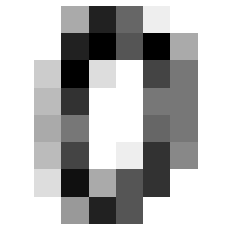

In [20]:
some_digit = X[0]
some_digit_image = some_digit.reshape(8, 8)

plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

In [21]:
y[0]

0

The label tell us that it is zero 0.

In [25]:
y = y.astype(np.uint8)

In [26]:
y

array([0, 1, 2, ..., 8, 9, 8], dtype=uint8)

In [35]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 8
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Saving figure more_digits_plot


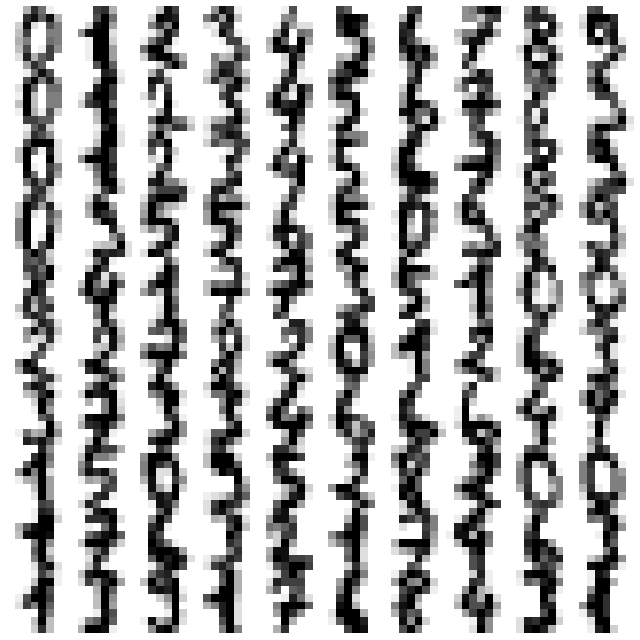

In [36]:
plt.figure(figsize=(9,9))
example_images = X[:100]
plot_digits(example_images, images_per_row=10)
save_fig("more_digits_plot")
plt.show()

------

# Training a Binary Classifier 
Let's try to solve a simple classification between 5 or not 5.

In [37]:
from sklearn.model_selection import train_test_split

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [39]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1437, 64), (360, 64), (1437,), (360,))

### As our problem is binary classification of 5 or not 5, we need to prepare for labels for 5.

In [40]:
y_train_5 = (y_train==5) # True for all 5s, False for all other digits
y_train_5

array([False, False, False, ..., False, False, False])

In [43]:
y_test_5 = (y_test == 5)

### Classification using SGD classifier (Stochastic Gradient Descent)
- has advantage or handling large dataset efficiently because SGD deals with training instances indenpently, one at a time.
- will suited for online learning.

**TIPS: The SGDClassifier relies on randomness during training (hence the name “stochastic”). If you want reproducible results, you should set the random_state parameter.**

In [44]:
from sklearn.linear_model import SGDClassifier

In [45]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [47]:
# test using our single digit which is 0
# returns False as prediction which is correct as this is not digit 5.
sgd_clf.predict([some_digit])

array([False])

------

# 3) Performance Measures